In [118]:
import numpy as np
import torch
from torch import nn 
from torch.utils.data import DataLoader,Dataset
from torchvision import models
import os
from torchvision import models, transforms, datasets
from collections import defaultdict
from shutil import copy
from torch.optim import lr_scheduler, Adam
from torch.autograd import Variable
FOOD_PATH = "./food-101/"
IMG_PATH = FOOD_PATH+"/images/"
META_PATH = FOOD_PATH+"/meta/"
TRAIN_PATH = FOOD_PATH+"/train/"
TEST_PATH = FOOD_PATH+"/valid/"
MODEL_PATH = 'model_data/'
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
from PIL import Image

In [90]:
class FOOD101():
    def __init__(self):
        self.train_ds, self.test_ds, self.train_cls, self.test_cls = [None]*4
        self.mean = (0.485, 0.456, 0.406)
        self.dis = (0.229, 0.224, 0.225)
    def get_data_extract(self):
        if "food-101" in os.listdir():
            print("Dataset already exists")
        else:
            print("Downloading the data...")
            !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
            print("Dataset downloaded!")
            print("Extracting data..")
            !tar xzvf food-101.tar.gz
            print("Extraction done!")
        
    def _get_tfms(self):
        train_tfms = transforms.Compose([
            transforms.Resize((512,512)), 
            transforms.ToTensor(),
            
            transforms.Normalize((0.5,0.5,0.5), (1,1,1))])
       
        test_tfms = transforms.Compose([
            transforms.Resize((512,512)),
            transforms.ToTensor(),
             
            transforms.Normalize((0.5,0.5,0.5), (1,1,1))])        
        return train_tfms, test_tfms            
            
    def get_dataset(self,root_dir='./food-101/'):
        train_tfms, test_tfms = self._get_tfms() # transformations
        self.train_ds = datasets.ImageFolder(root=TRAIN_PATH, transform=train_tfms)
        self.test_ds = datasets.ImageFolder(root=TEST_PATH, transform=test_tfms)        
        self.train_classes = self.train_ds.classes
        self.test_classes = self.test_ds.classes

        assert self.train_classes==self.test_classes
        return self.train_ds, self.test_ds, self.train_classes

    
    def get_dls(self, train_ds, test_ds, bs, **kwargs):
        return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
               DataLoader(test_ds, batch_size=bs//2, shuffle=False, **kwargs))
    
food = FOOD101()

In [91]:
food.get_data_extract()

Dataset already exists


In [92]:
def prepare_data(filepath, src, dest):
    classes_images = defaultdict(list)
    with open(filepath, 'r') as txt:
        paths = [read.strip() for read in txt.readlines()]
        for p in paths:
            food = p.split('/')
            classes_images[food[0]].append(food[1] + '.jpg')

    for food in classes_images.keys():
        print("\nCopying images into ",food)
        if not os.path.exists(os.path.join(dest,food)):
            os.makedirs(os.path.join(dest,food))
        for i in classes_images[food]:
            copy(os.path.join(src,food,i), os.path.join(dest,food,i))
    print("Copying Done!")

In [93]:
#print("Creating train data...")
#prepare_data(META_PATH+'train.txt', IMG_PATH, TRAIN_PATH)

In [94]:
#print("Creating test data...")
#prepare_data(META_PATH+'test.txt', IMG_PATH, TEST_PATH)

In [95]:
train, test, classes =  food.get_dataset()
train, test = food.get_dls(train, test, bs=4, num_workers=0)

In [96]:
classes

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [97]:
def imshow(axis, inp):
    """Denormalize and show"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([1, 1, 1])
    inp = std * inp + mean
    axis.imshow(inp)

torch.Size([4, 3, 512, 512]) torch.Size([4])
sashimi
clam_chowder
eggs_benedict
churros


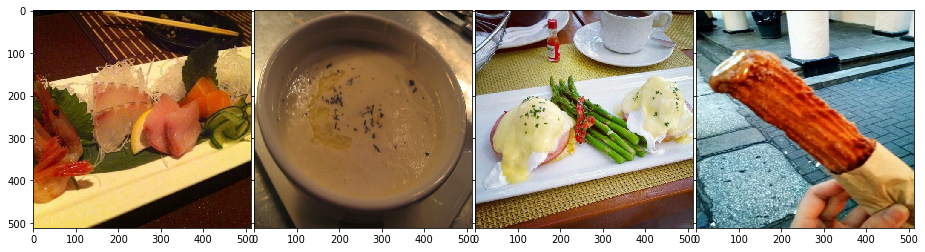

In [105]:
img, label = next(iter(train))
print(img.size(), label.size())
fig = plt.figure(1, figsize=(16, 4))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.05)    
for i in range(img.size()[0]):
    ax = grid[i]
    imshow(ax, img[i])
    print(classes[label[i].numpy()])

In [127]:
model = models.resnet50(pretrained = True)
img, label = next(iter(train))
outputs = model(img)
outputs.size()

torch.Size([4, 1000])

In [128]:
for param in model.parameters():
    param.requires_grad = False

In [129]:
len(classes)

101

In [130]:
torch.cuda.is_available()

True

In [131]:
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 101)

In [134]:
model = model.cuda()

In [135]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = Adam(model.fc.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [136]:
def train_model(dataloders, model, criterion, optimizer, scheduler, num_epochs=25):
    best_acc = 0.0
    for epoch in range(num_epochs):
        scheduler.step()
        model.train(True)
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloders:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.data.item()
            running_corrects += torch.sum(preds == labels.data)

            train_epoch_loss = running_loss / len(inputs)
            train_epoch_acc = running_corrects / len(inputs)

    print('Epoch [{}/{}] train loss: {:.4f} acc: {:.4f} ' 
          .format(
            epoch, num_epochs - 1,
            train_epoch_loss, train_epoch_acc))


    return model

In [ ]:
model = train_model(train, model, criterion, optimizer, exp_lr_scheduler, num_epochs=2)

/home/pe/.conda/envs/pycode/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
